In [13]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd 
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
import gc
import re
import torch
import torch.nn as nn
import emoji as emoji
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizerFast as BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, multilabel_confusion_matrix
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import TweetTokenizer
from matplotlib import rc
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import string
import torch.optim as optim
%matplotlib inline
%config InlineBackend.figure_format='retina'
RANDOM_SEED = 42
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/hate-speech-detection/sample_submission.csv
/kaggle/input/hate-speech-detection/train.csv
/kaggle/input/hate-speech-detection/test.csv
/kaggle/input/hatespeech/train.csv


In [14]:
traindf = pd.read_csv("/kaggle/input/hatespeech/train.csv")
print(traindf.head())
# traindf, val_df = train_test_split(df, test_size=0.05)
# traindf.shape, val_df.shape

     id                                               text  HS  TR  AG
0  6452  @indigomermaidd You're the exception , you wer...   1   1   0
1  4884  If a woman doesn't want you just unleash your ...   1   0   0
2  1931  Son of Jamestown, Protestants that made the US...   0   0   0
3  4942  Literally just got hit by a car bc this dumb b...   1   1   0
4  4721  charli: fuck you bitch charli: omg why am i so...   1   1   0


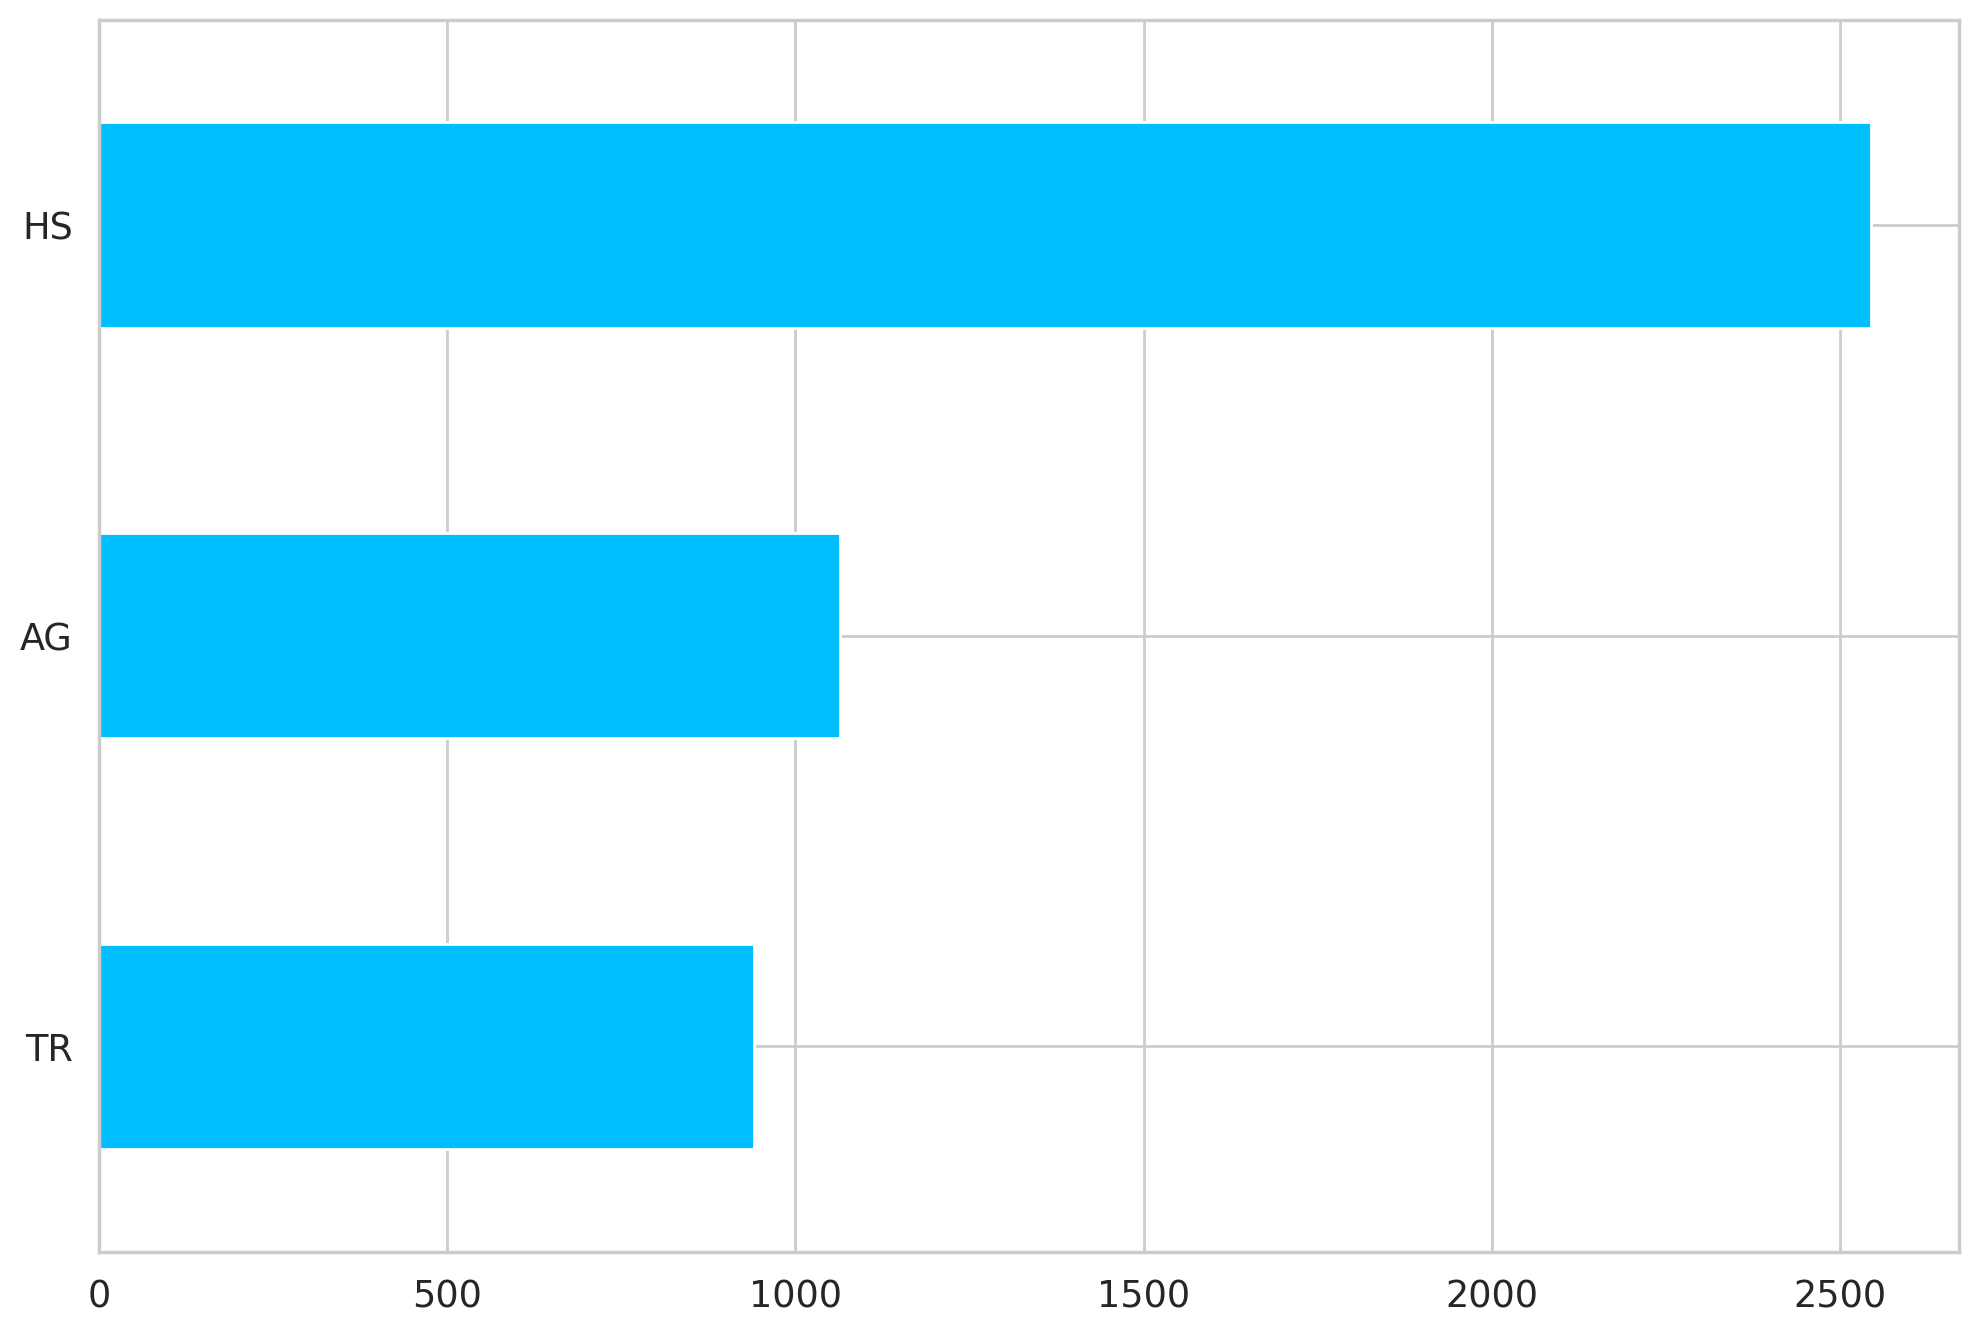

In [15]:
LABEL_COLUMNS = traindf.columns.tolist()[2:]
traindf[LABEL_COLUMNS].sum().sort_values().plot(kind="barh");

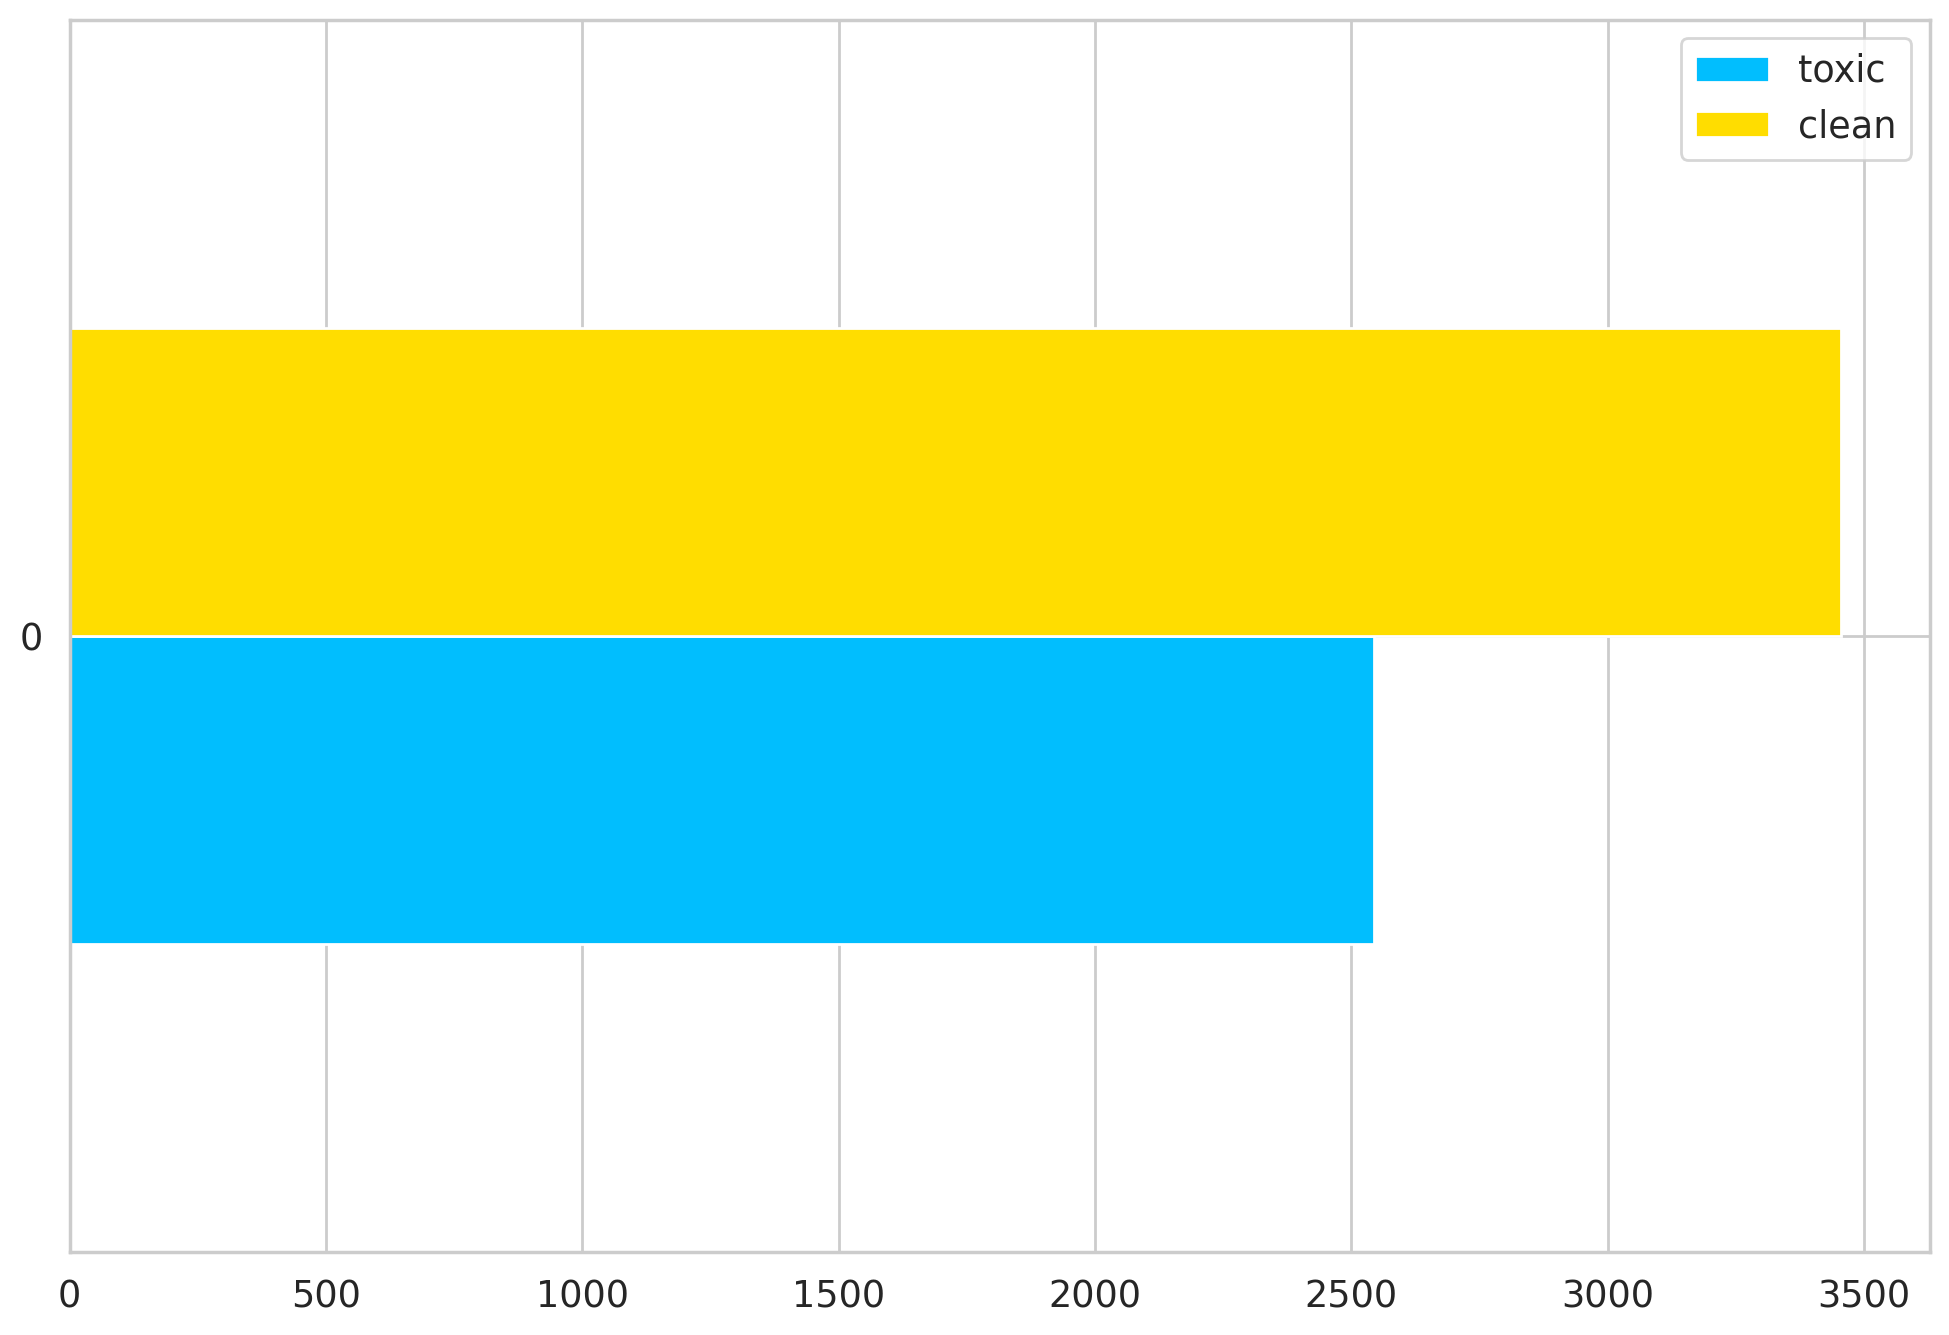

In [16]:
train_toxic = traindf[traindf[LABEL_COLUMNS].sum(axis=1) > 0]
train_clean = traindf[traindf[LABEL_COLUMNS].sum(axis=1) == 0]
pd.DataFrame(dict(
  toxic=[len(train_toxic)],
  clean=[len(train_clean)]
)).plot(kind='barh');

In [17]:
class BERTM_Arch(nn.Module):
  def __init__(self, bert, n_class):
    super(BERTM_Arch, self).__init__()
    self.bert = bert
    self.dropout = nn.Dropout(0.1)  
    self.relu =  nn.ReLU()
    self.fc1 = nn.Linear(768,512)
    self.fc2 = nn.Linear(512,n_class)
    self.softmax = nn.LogSoftmax(dim=1)

  def forward(self, sent_id, mask):
    outputs = self.bert(sent_id, attention_mask=mask)
    #[32, 768]
    #Extract the last hidden state of the token `[CLS]` for classification task
    last_hidden_state_cls = outputs[0][:, 0, :]
    x = self.fc1(self.dropout(last_hidden_state_cls))
    x = self.relu(x)
    x = self.dropout(x)
    x = self.fc2(x)  
    x = self.softmax(x)
    return x

In [18]:
def read_dataset(ty):
    
    train_labels = traindf[ty]

    return traindf['text'].tolist(), train_labels


def tokenize(tweet):
    # instantiate the tokenizer class
    tokenizer = TweetTokenizer(preserve_case=False, 
                              strip_handles=True,
                              reduce_len=True)

    # tokenize the tweets
    tweet_tokens = tokenizer.tokenize(tweet)

    tweets_clean = []
    for word in tweet_tokens: # Go through every word in your tokens list
        if word not in string.punctuation:  # remove punctuation
            tweets_clean.append(word)
    result = tweets_clean
    return " ".join(result)

emoticons = [':-)', ':)', '(:', '(-:', ':))', '((:', ':-D', ':D', 'X-D', 'XD', 'xD', 'xD', '<3', '</3', ':\*',
                 ';-)',
                 ';)', ';-D', ';D', '(;', '(-;', ':-(', ':(', '(:', '(-:', ':,(', ':\'(', ':"(', ':((', ':D', '=D',
                 '=)',
                 '(=', '=(', ')=', '=-O', 'O-=', ':o', 'o:', 'O:', 'O:', ':-o', 'o-:', ':P', ':p', ':S', ':s', ':@',
                 ':>',
                 ':<', '^_^', '^.^', '>.>', 'T_T', 'T-T', '-.-', '*.*', '~.~', ':*', ':-*', 'xP', 'XP', 'XP', 'Xp',
                 ':-|',
                 ':->', ':-<', '$_$', '8-)', ':-P', ':-p', '=P', '=p', ':*)', '*-*', 'B-)', 'O.o', 'X-(', ')-X']

def preprocess(tweet):
    result = tweet.replace('rt @','@')
    result = result.replace('@','<user> @')
    # it will remove hyperlinks
    result = re.sub(r'https?:\/\/.*[\r\n]*', '<url>', result)

    # it will remove hashtags. We have to be careful here not to remove 
    # the whole hashtag because text of hashtags contains huge information. 
    # only removing the hash # sign from the word
    result = re.sub(r'#', '<hashtag>', result)

    # Replace multiple dots with space
    result = re.sub('\.\.+', ' ', result) 



    for char in result:
        if emoji.is_emoji(char):
            result = result.replace(char, "<emoticon >")
    for emo in emoticons:
        result = result.replace(emo, "<emoticon >")

    result = tokenize(result)
    # it will remove single numeric terms in the tweet. 
    result = re.sub(r'[0-9]+', '<number>', result)
    result = re.sub(r'<number>\s?st', '<number>', result)
    result = re.sub(r'<number>\s?nd', '<number>', result)
    result = re.sub(r'<number>\s?rd', '<number>', result)
    result = re.sub(r'<number>\s?th', '<number>', result)

    return result

def pre_process_dataset(values):
    new_values = list()
    for value in values:
        new_values.append(preprocess(value.lower()))
#     print(values[:5])
#     print(new_values[:5])
    return new_values


In [19]:
def data_process(data, labels):
    input_ids = []
    attention_masks = []
    bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
    for sentence in data:
        bert_inp = bert_tokenizer.__call__(sentence, max_length=36,
                                           padding='max_length', pad_to_max_length=True,
                                           truncation=True, return_token_type_ids=False)

        input_ids.append(bert_inp['input_ids'])
        attention_masks.append(bert_inp['attention_mask'])

    input_ids = np.asarray(input_ids)
    attention_masks = np.array(attention_masks)
    labels = np.array(labels)
    return input_ids, attention_masks, labels

In [20]:
def load_and_process(ty):

    data, labels = read_dataset(ty)
#     num_of_labels = len(labels.unique())
    input_ids, attention_masks, labels = data_process(pre_process_dataset(data), labels)

    return input_ids, attention_masks, labels

In [21]:
# function to train the model
def train(model,optimizer,train_dataloader,batch_size):
    model.train()

    total_loss, total_accuracy = 0, 0

    # empty list to save model predictions
    total_preds = []

    # iterate over batches
    total = len(train_dataloader)
    for i, batch in enumerate(train_dataloader):

        step = i+1
        percent = "{0:.2f}".format(100 * (step / float(total)))
        lossp = "{0:.2f}".format(total_loss/(total*batch_size))
        filledLength = int(100 * step // total)
        bar = '█' * filledLength + '>'  *(filledLength < 100) + '.' * (99 - filledLength)
        print(f'\rBatch {step}/{total} |{bar}| {percent}% complete, loss={lossp}, accuracy={total_accuracy}', end='')

        # push the batch to gpu
        batch = [r.to(device) for r in batch]
        sent_id, mask, labels = batch
        del batch
        gc.collect()
        torch.cuda.empty_cache()
        # clear previously calculated gradients
        model.zero_grad()

        preds = model(sent_id, mask)

        # compute the loss between actual and predicted values
        labels_tensor = labels.clone().detach().to(device).long()
        loss = cross_entropy(preds, labels_tensor)

        # add on to the total loss
        total_loss += float(loss.item())

        # backward pass to calculate the gradients
        loss.backward()

        # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # update parameters
        optimizer.step()

        total_preds.append(preds.detach().cpu().numpy())

    gc.collect()
    torch.cuda.empty_cache()

    # compute the training loss of the epoch
    avg_loss = total_loss / (len(train_dataloader)*batch_size)

    total_preds = np.concatenate(total_preds, axis=0)

    # returns the loss and predictions
    return avg_loss, total_preds


In [22]:
# function for evaluating the model
def evaluate(model,val_dataloader,batch_size):
    print("\n\nEvaluating...")

    # deactivate dropout layers
    model.eval()

    total_loss, total_accuracy = 0, 0

    # empty list to save the model predictions
    total_preds = []

    # iterate over batches
    total = len(val_dataloader)
    for i, batch in enumerate(val_dataloader):
        
        step = i+1
        percent = "{0:.2f}".format(100 * (step / float(total)))
        lossp = "{0:.2f}".format(total_loss/(total*batch_size))
        filledLength = int(100 * step // total)
        bar = '█' * filledLength + '>' * (filledLength < 100) + '.' * (99 - filledLength)
        print(f'\rBatch {step}/{total} |{bar}| {percent}% complete, loss={lossp}, accuracy={total_accuracy}', end='')

        # push the batch to gpu
        batch = [t.to(device) for t in batch]

        sent_id, mask, labels = batch
        del batch
        gc.collect()
        torch.cuda.empty_cache()
        # deactivate autograd
        with torch.no_grad():

            # model predictions
            preds = model(sent_id, mask)


            labels_tensor = labels.clone().detach().to(device).long()
            loss = cross_entropy(preds, labels_tensor)

            total_loss += float(loss.item())
            #preds = preds.detach().cpu().numpy()

            #total_preds.append(preds)
            total_preds.append(preds.detach().cpu().numpy())

    gc.collect()
    torch.cuda.empty_cache()

    # compute the validation loss of the epoch
    avg_loss = total_loss / (len(val_dataloader)*batch_size)

    # reshape the predictions in form of (number of samples, no. of classes)
    total_preds = np.concatenate(total_preds, axis=0)

    return avg_loss, total_preds

In [23]:
# Specify the GPU
# Setting up the device for GPU usage
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

# loss function
#cross_entropy = nn.NLLLoss(weight=weights)
cross_entropy = nn.NLLLoss()

cuda


In [24]:
def modelss(ty):

    # Load Dataset
    input_ids, attention_masks, labels = load_and_process(ty)
    df = pd.DataFrame(list(zip(input_ids, attention_masks)), columns=['input_ids', 'attention_masks'])

    # Class distribution
    train_text, val_text, train_labels, val_labels = train_test_split(df, labels, test_size=0.05, random_state=42)

    gc.collect()
    torch.cuda.empty_cache()

    train_count = len(train_labels)
    val_count = len(val_labels)


    # for train set
    train_seq = torch.tensor(train_text['input_ids'].tolist())
    train_mask = torch.tensor(train_text['attention_masks'].tolist())
    train_y = torch.tensor(train_labels.astype(int))

    # for validation set
    val_seq = torch.tensor(val_text['input_ids'].tolist())
    val_mask = torch.tensor(val_text['attention_masks'].tolist())
    val_y = torch.tensor(val_labels.astype(int))



    # define a batch size
    batch_size = 32
    learning_rate = 2e-5

    # wrap tensors
    train_data = TensorDataset(train_seq, train_mask, train_y)
    # sampler for sampling the data during training
    train_sampler = RandomSampler(train_data)
    # dataLoader for train set
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

    # wrap tensors
    val_data = TensorDataset(val_seq, val_mask, val_y)
    # sampler for sampling the data during training
    val_sampler = SequentialSampler(val_data)
    # dataLoader for validation set
    val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)


    # import BERT-base pretrained model
    bert = BertModel.from_pretrained('bert-base-uncased')


    # freeze all the parameters
    for param in bert.parameters():
        param.requires_grad = False


    # pass the pre-trained BERT to our define architecture
    model = BERTM_Arch(bert, len(np.unique(labels)))
    # push the model to GPU
    model = model.to(device)



    # define the optimizer
    # optimizer = AdamW(model.parameters(), lr=2e-5)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)



    # set initial loss to infinite
    best_valid_loss = float('inf')


    epochs = 4
    current = 1
    # for each epoch
    while current <= epochs:

        print(f'\nEpoch {current} / {epochs}:')

        # train model
        train_loss, _ = train(model,optimizer,train_dataloader,batch_size)

        # evaluate model
        valid_loss, preds = evaluate(model,val_dataloader,batch_size)

        # save the best model
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), f'model_{ty}.pth')


        print(f'\n\nTraining Loss: {train_loss:.3f}')
        print(f'Validation Loss: {valid_loss:.3f}')
        
        preds = np.argmax(preds, axis=1)
        print(classification_report(val_y, preds))

        current = current + 1

    # get predictions for test data
    gc.collect()
    torch.cuda.empty_cache()

In [25]:
modelss('HS')

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

/tmp/ipykernel_33/4163821370.py:18: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:261.)
  train_seq = torch.tensor(train_text['input_ids'].tolist())


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]


Epoch 1 / 4:
Batch 179/179 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.00% complete, loss=0.02, accuracy=0

Evaluating...
Batch 10/10 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.00% complete, loss=0.02, accuracy=0

Training Loss: 0.021
Validation Loss: 0.019
              precision    recall  f1-score   support

           0       0.66      0.98      0.79       185
           1       0.84      0.18      0.30       115

    accuracy                           0.67       300
   macro avg       0.75      0.58      0.54       300
weighted avg       0.73      0.67      0.60       300


Epoch 2 / 4:
Batch 179/179 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.00% complete, loss=0.02, accuracy=0

Evaluating...
Batch 10/10 |████████████████████████████████████████████████████████████████████████████████████████

In [26]:
modelss('AG')


Epoch 1 / 4:
Batch 179/179 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.00% complete, loss=0.02, accuracy=0

Evaluating...
Batch 10/10 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.00% complete, loss=0.01, accuracy=0

Training Loss: 0.016
Validation Loss: 0.016
              precision    recall  f1-score   support

           0       0.80      1.00      0.89       241
           1       0.00      0.00      0.00        59

    accuracy                           0.80       300
   macro avg       0.40      0.50      0.45       300
weighted avg       0.65      0.80      0.72       300


Epoch 2 / 4:
Batch 1/179 |>...................................................................................................| 0.56% complete, loss=0.00, accuracy=0

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Batch 179/179 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.00% complete, loss=0.01, accuracy=0

Evaluating...
Batch 10/10 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.00% complete, loss=0.01, accuracy=0

Training Loss: 0.014
Validation Loss: 0.015
              precision    recall  f1-score   support

           0       0.80      1.00      0.89       241
           1       0.00      0.00      0.00        59

    accuracy                           0.80       300
   macro avg       0.40      0.50      0.45       300
weighted avg       0.65      0.80      0.72       300


Epoch 3 / 4:
Batch 1/179 |>...................................................................................................| 0.56% complete, loss=0.00, accuracy=0

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Batch 179/179 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.00% complete, loss=0.01, accuracy=0

Evaluating...
Batch 10/10 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.00% complete, loss=0.01, accuracy=0

Training Loss: 0.014
Validation Loss: 0.015
              precision    recall  f1-score   support

           0       0.80      1.00      0.89       241
           1       0.00      0.00      0.00        59

    accuracy                           0.80       300
   macro avg       0.40      0.50      0.45       300
weighted avg       0.65      0.80      0.72       300


Epoch 4 / 4:
Batch 1/179 |>...................................................................................................| 0.56% complete, loss=0.00, accuracy=0

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Batch 179/179 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.00% complete, loss=0.01, accuracy=0

Evaluating...
Batch 10/10 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.00% complete, loss=0.01, accuracy=0

Training Loss: 0.014
Validation Loss: 0.014
              precision    recall  f1-score   support

           0       0.80      1.00      0.89       241
           1       0.00      0.00      0.00        59

    accuracy                           0.80       300
   macro avg       0.40      0.50      0.45       300
weighted avg       0.65      0.80      0.72       300



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [27]:
modelss('TR')


Epoch 1 / 4:
Batch 179/179 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.00% complete, loss=0.01, accuracy=0

Evaluating...
Batch 10/10 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.00% complete, loss=0.01, accuracy=0

Training Loss: 0.014
Validation Loss: 0.012
              precision    recall  f1-score   support

           0       0.85      1.00      0.92       254
           1       0.00      0.00      0.00        46

    accuracy                           0.85       300
   macro avg       0.42      0.50      0.46       300
weighted avg       0.72      0.85      0.78       300


Epoch 2 / 4:
Batch 1/179 |>...................................................................................................| 0.56% complete, loss=0.00, accuracy=0

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Batch 179/179 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.00% complete, loss=0.01, accuracy=0

Evaluating...
Batch 10/10 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.00% complete, loss=0.01, accuracy=0

Training Loss: 0.011
Validation Loss: 0.010
              precision    recall  f1-score   support

           0       0.85      1.00      0.92       254
           1       0.00      0.00      0.00        46

    accuracy                           0.85       300
   macro avg       0.42      0.50      0.46       300
weighted avg       0.72      0.85      0.78       300


Epoch 3 / 4:
Batch 1/179 |>...................................................................................................| 0.56% complete, loss=0.00, accuracy=0

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Batch 179/179 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.00% complete, loss=0.01, accuracy=0

Evaluating...
Batch 10/10 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.00% complete, loss=0.01, accuracy=0

Training Loss: 0.011
Validation Loss: 0.010
              precision    recall  f1-score   support

           0       0.86      1.00      0.93       254
           1       0.86      0.13      0.23        46

    accuracy                           0.86       300
   macro avg       0.86      0.56      0.58       300
weighted avg       0.86      0.86      0.82       300


Epoch 4 / 4:
Batch 179/179 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.00% complete, loss=0.01, accuracy=0

Evaluating...
Batch 10/10 |████████████████████████████████████████████████████████████████████████████████████████████████████| 

In [28]:
# Load test data
test_df = pd.read_csv('/kaggle/input/hate-speech-detection/test.csv')
test_data = pre_process_dataset(test_df['text'].tolist())

# Load BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert = BertModel.from_pretrained('bert-base-uncased')

# Initialize an empty DataFrame to store predictions
predictions_df = pd.DataFrame({'id': test_df['id']})

# Define the labels
labels = ['HS', 'TR', 'AG']

# Iterate over each label
for label in labels:
    # Load the corresponding model
    model_path = f'/kaggle/working/model_{label}.pth'  # Adjust the path as needed
    model = BERTM_Arch(bert, 2)  
    model.load_state_dict(torch.load(model_path))
    model = model.to(device)
    
    # Tokenize the test data
    test_seq = torch.tensor([tokenizer.encode(i, max_length=36, pad_to_max_length=True) for i in test_data])
    test_mask = torch.tensor([[float(i > 0) for i in ii] for ii in test_seq])
    
    # Get predictions for test data
    with torch.no_grad():
        preds = model(test_seq.to(device), test_mask.to(device))
        preds = preds.detach().cpu().numpy()
    
    # Get the predicted labels
    predictions_df[label] = np.argmax(preds, axis=1)

# Apply conditions to the predictions
predictions_df['TR'] = predictions_df.apply(lambda row: row['TR'] if row['HS'] == 1 else 0, axis=1)
predictions_df['AG'] = predictions_df.apply(lambda row: row['AG'] if row['HS'] == 1 else 0, axis=1)

# Round the predictions to binary values (0 or 1)
predictions_df = predictions_df.round().astype(int)

# Save the predictions to a CSV file
predictions_df.to_csv('/kaggle/working/predictions.csv', index=False)


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2688: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2688: FutureWarning